<h3>Implementing Deep Neural Network from scratch</h3>

Trying parameters - Hidden Nodes: 20 Learning Rate: 0.000100 Batch Size: 64 Epochs: 11
Epochs: 0 Cost: 1.10111 Validation Acc: 75.98 ||w1||: 12.61778 ||w2||: 2.50995
Epochs: 2 Cost: 0.45358 Validation Acc: 86.64 ||w1||: 12.90641 ||w2||: 3.75690
Epochs: 4 Cost: 0.45120 Validation Acc: 88.68 ||w1||: 13.04749 ||w2||: 4.23276
Epochs: 6 Cost: 0.35244 Validation Acc: 89.84 ||w1||: 13.13676 ||w2||: 4.50825
Epochs: 8 Cost: 0.34841 Validation Acc: 90.58 ||w1||: 13.20252 ||w2||: 4.69907
Epochs: 10 Cost: 0.36588 Validation Acc: 91.02 ||w1||: 13.25638 ||w2||: 4.84690
Current best parameters - Hidden Nodes: 20 Learning Rate: 0.000100 Batch Size: 64 Epochs: 11
Trying parameters - Hidden Nodes: 20 Learning Rate: 0.000100 Batch Size: 32 Epochs: 11
Epochs: 0 Cost: 1.07801 Validation Acc: 73.10 ||w1||: 12.63566 ||w2||: 2.49424
Epochs: 2 Cost: 0.58265 Validation Acc: 85.34 ||w1||: 12.91928 ||w2||: 3.71892
Epochs: 4 Cost: 0.47113 Validation Acc: 88.66 ||w1||: 13.06832 ||w2||: 4.21637
Epochs: 6 Cost: 0.405

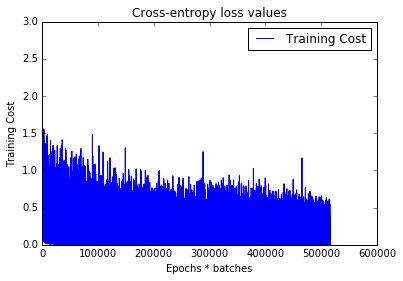

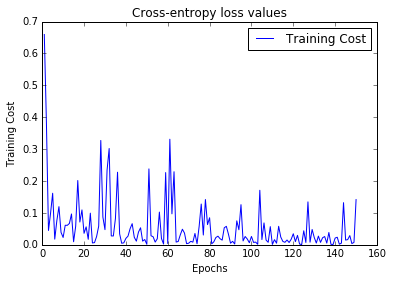

Best cost: 0.14179 Best epoch: 149 
Execution time 653 sec
Training cost: 0.0323654383245
Validation cost:  0.127987034192
Testing cost:  0.13699136092
Accuracy on Validation set:  96.84 %
Accuracy on Testing set:  96.6 %


In [255]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import math

def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)
    ans = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    return ans


def relu(z):
    z[z < 0] = 0
    return z


def relu_prime(z):
    z[z <= 0] = 0
    z[z > 0] = 1
    return z


def stochastic_J(y_hat, images, labels, alpha=0.):
    x = images
    y = labels
    m = x.shape[0]
    cost_mat = np.multiply(y, np.log(y_hat))
    cost = (-1. / m) * np.sum(np.sum(cost_mat, axis=1))
    #     cost += (alpha / (2 * m)) * np.linalg.norm(w)
    return cost


def J(w1, w2, b1, b2, images, labels,
      alpha=0.):  # TODO: Temp scaffold, remove this later on merge with the above function
    x = images
    y = labels
    m = x.shape[0]
    h1, y_hat = feedforward(w1, w2, b1, b2, x, y)
    cost_mat = np.multiply(y, np.log(y_hat))
    cost = (-1. / m) * np.sum(np.sum(cost_mat, axis=1))
    #     cost += (alpha / (2 * m)) * np.linalg.norm(w)
    return cost


def feedforward(w1, w2, b1, b2, images, labels, aplha=.0):
    x = images
    h1 = relu(x.dot(w1.T) + b1)
    y_hat = softmax(h1.dot(w2.T) + b2)
    return h1, y_hat


def grad_layer2(h1, y_hat, images, labels, alpha=0.):
    x = images
    y = labels
    h2 = (y_hat - y)
    dJ_dw2 = h2.T.dot(h1)
#     dJ_b2 = np.sum(h2, axis=0, keepdims=True)
    dJ_b2 = np.mean(h2, axis=0, keepdims=True)
    return dJ_dw2, dJ_b2


def grad_layer1(h1, y_hat, w_1, w_2, images, labels, alpha=0.):
    x = images
    y = labels
    dJ_dh1 = (y_hat - y).dot(w_2)
    g = dJ_dh1 * relu_prime(x.dot(w_1.T))
    dJ_dw1 = g.T.dot(x)
#     dJ_db1 = np.sum(g, axis=0, keepdims=True)
    dJ_db1 = np.mean(g, axis=0, keepdims=True)
    return dJ_dw1, dJ_db1


def gradientDescent(trainingimages, trainingLabels, h_nodes, epsilon, batch_size, epochs, alpha=0., searching=False):
    x = trainingimages
    y = trainingLabels
    sample_size, dimensions = x.shape
    classes = y.shape[1]
    cost_history = np.array([])
    batch_history = np.array([])

    mu, sigma = 0, 0.1
    tmp_w1 = np.random.normal(mu, sigma, (h_nodes, dimensions))
#     w1 = w1 * math.sqrt(2.0/h_nodes) #He et al.
    tmp_b1 = np.ones((1, h_nodes))
    tmp_w2 = np.random.normal(mu, sigma, (classes, h_nodes))
#     w2 = w2 * math.sqrt(2.0/classes)
    tmp_b2 = np.ones((1, classes))
    w2, b2 = tmp_w2, tmp_b2
    w1, b1 = tmp_w1, tmp_b1
    best_cost, best_epoch = 0, 0
    
    num_batches = sample_size / batch_size
    for e in xrange(epochs):
        x_y = np.append(x, y, axis=1)
        np.random.shuffle(x_y)
        x_s = x_y[:, :dimensions]
        y_s = x_y[:, dimensions:]
        for i in xrange(num_batches):
            start = i * batch_size
            end = start + batch_size
            x_batch = x_s[start:end]
            y_batch = y_s[start:end]
            
            h1, y_hat = feedforward(tmp_w1, tmp_w2, tmp_b1, tmp_b2, x_batch, y_batch)  # Do feedforward pass
            cost1 = stochastic_J(y_hat, x_batch, y_batch, alpha)
            
            gradw1, gradb1 = grad_layer1(h1, y_hat, tmp_w1, tmp_w2, x_batch, y_batch)
            tmp_w1 -= (epsilon * gradw1)
            tmp_b1 -= (epsilon * gradb1)
            gradw2, gradb2 = grad_layer2(h1, y_hat, x_batch, y_batch)
            tmp_w2 -= (epsilon * gradw2)
            tmp_b2 -= (epsilon * gradb2)
            
            
            h1, y_hat = feedforward(tmp_w1, tmp_w2, tmp_b1, tmp_b2, x_batch, y_batch)  # Do feedforward pass
            cost2 = stochastic_J(y_hat, x_batch, y_batch, alpha)
            if cost2 < cost1:
                w2, b2 = tmp_w2, tmp_b2
                w1, b1 = tmp_w1, tmp_b1
                best_cost, best_epoch = cost2, e
            cost = cost2
            batch_history = np.append(batch_history, cost)

        cost_history = np.append(cost_history, cost)
        batch_acc = report_accuracy(w1, w2, b1, b2, validationImages, validationLabels)
        if e % 2 == 0:
            # print "Epochs: ", e, "Cost: ", cost, " Validation acc: ", batch_acc, "||w1|| :", np.linalg.norm(w1), "||w2|| :", np.linalg.norm(w2)
            print("Epochs: %d Cost: %.5f Validation Acc: %.2f ||w1||: %.5f ||w2||: %.5f" % (
                e,cost,batch_acc,np.linalg.norm(w1), np.linalg.norm(w2)))

    if (searching):
        return cost, batch_acc

    plt.plot(np.linspace(1, epochs * num_batches, epochs * num_batches), batch_history, label="Training Cost")
    plt.legend()
    plt.ylabel('Training Cost')
    plt.xlabel('Epochs * batches')
    plt.title("Cross-entropy loss values")
    plt.show()
    plt.plot(np.linspace(1, epochs, epochs), cost_history, label="Training Cost")
    plt.legend()
    plt.ylabel('Training Cost')
    plt.xlabel('Epochs')
    plt.title("Cross-entropy loss values")
    plt.show()
    print ("Best cost: %.5f Best epoch: %d " % (best_cost, best_epoch))
    return w1, w2, b1, b2


def reportCosts(w1, w2, b1, b2, trainImg , trainLbl, valiImg, valiLbl, testImg, testLbl, alpha=0.):
    print "Training cost: {}".format(J(w1, w2, b1, b2, trainImg, trainLbl, alpha))
    print "Validation cost:  {}".format(J(w1, w2, b1, b2, valiImg, valiLbl, alpha))
    print "Testing cost:  {}".format(J(w1, w2, b1, b2, testImg, testLbl, alpha))


def report_accuracy(w1, w2, b1, b2, images, labels):
    h1, y_hat = feedforward(w1, w2, b1, b2, images, labels)
    acc = np.mean(np.argmax(y_hat, axis=1) == np.argmax(labels, axis=1))
    return acc * 100


def predict(images, labels, w1, w2, b1, b2):
    h1, y_hat = feedforward(w1, w2, b1, b2, images, labels)
    predicted = np.argmax(y_hat)
    real = np.argmax(labels)
    return predicted, real

def findBestHyperparameters():
    h_nodes = [20, 20, 20, 30, 30, 30, 40, 40, 20, 30]
    l_rate = [1e-4, 1e-4, 1e-5, 0.0005, 0.00002, 0.00001, 0.0006, 0.0006, 0.00007, 0.0006]
    b_size = [64, 32, 64, 128, 512, 256, 16, 64, 36, 16]
    epochs = 11
    min_cost = 100
    max_acc = 0
    best = 0
    for i in range(10):
        print ("Trying parameters - Hidden Nodes: %d Learning Rate: %.6f Batch Size: %d Epochs: %d" % (
            h_nodes[i], l_rate[i], b_size[i], epochs))
        cost, acc = gradientDescent(trainingImages, trainingLabels, h_nodes[i], l_rate[i], b_size[i], epochs, alpha, searching=True)
        if cost < min_cost:
            min_cost = cost
            best = i
        if acc > max_acc:
            max_acc = acc
            best = i
        print ("Current best parameters - Hidden Nodes: %d Learning Rate: %.6f Batch Size: %d Epochs: %d" % (
            h_nodes[best], l_rate[best], b_size[best], epochs))
    return h_nodes[i], l_rate[i], b_size[i], 150

if __name__ == "__main__":
    # Load data
    if ('trainingImages' not in globals()):
        trainingImages = np.load("datasets/mnist_train_images.npy")
        trainingLabels = np.load("datasets/mnist_train_labels.npy")
        validationImages = np.load("datasets/mnist_validation_images.npy")
        validationLabels = np.load("datasets/mnist_validation_labels.npy")
        testingImages = np.load("datasets/mnist_test_images.npy")
        testingLabels = np.load("datasets/mnist_test_labels.npy")

    import time

    start = time.time()
    alpha = 0
    h_nodes, l_rate, b_size, epochs = findBestHyperparameters()
#     h_nodes, l_rate, b_size, epochs = 30, 1e-5, 500, 50
    print ("Best parameters - Hidden Nodes: %d Learning Rate: %.6f Batch Size: %d Epochs: %d" % (h_nodes, l_rate, b_size, epochs))
    w1, w2, b1, b2 = gradientDescent(trainingImages, trainingLabels, h_nodes, l_rate, b_size, epochs, alpha)

    dt = int(time.time() - start)
    print("Execution time %d sec" % dt)

    reportCosts(w1, w2, b1, b2, trainingImages, trainingLabels, validationImages, validationLabels, testingImages, testingLabels)
    print "Accuracy on Validation set: ", report_accuracy(w1, w2, b1, b2, validationImages, validationLabels), "%"
    print "Accuracy on Testing set: ", report_accuracy(w1, w2, b1, b2, testingImages, testingLabels), "%"


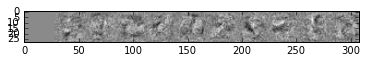

In [256]:
        image = np.zeros((28,28))
        for i in xrange(0,10):
            temp = w1[i].reshape(28,28)
            image = np.concatenate((image,temp), axis=1)
        img_plt = plt.imshow(image, cmap='gray')
        plt.show(img_plt)

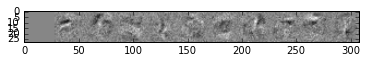

In [257]:
        image = np.zeros((28,28))
        for i in xrange(10,20):
            temp = w1[i].reshape(28,28)
            image = np.concatenate((image,temp), axis=1)
        img_plt = plt.imshow(image, cmap='gray')
        plt.show(img_plt)

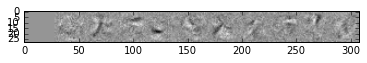

In [258]:
        image = np.zeros((28,28))
        for i in xrange(20,30):
            temp = w1[i].reshape(28,28)
            image = np.concatenate((image,temp), axis=1)
        img_plt = plt.imshow(image, cmap='gray')
        plt.show(img_plt)

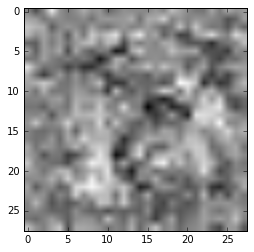

In [259]:
image = w1[9].reshape(28,28)
img_plt = plt.imshow(image, cmap='gray')
plt.show(img_plt)

<h3>Visual Check for test images and predicted labels</h3>

In [250]:
def draw_image(x, y, title_str, drawTest = False):
    for c in range(1, 10):
        plt.subplot(3, 3,c)
        i = np.random.randint(x.shape[0]) 
        predicted, real = predict(x[i], y[i], w1, w2, b1, b2)
        im = testingImages[i].reshape((28,28)) 
        plt.axis("off")
        label = predicted
        plt.title("{} = {}".format(title_str, label))
        plt.imshow(im, cmap='gray')

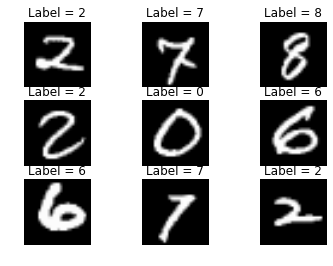

In [251]:
draw_image(testingImages, testingLabels, "Label")